This notebook addresses open shop scheduling problem. 

There is a set of *n* jobs, a set of *m* machines, and each job is associated with a set of operations. Each job can be processed only at one machine at a time, and each machine can process only one job at a time. Unlike the job-shop problem, the order in which the job operations happen can vary freely (not predefined). The objective is minimizing the completion time of latest job (makespan).

This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 10
jobs_list = [*range(0,nbrOfJobs)] 

In [2]:
nbrOfMachines = 3
machines_list = [*range(0, nbrOfMachines)] 

In [3]:
#randomly generate processing time of jobs' operations on each machine
import random
minProcessingTime=10
maxProcessingTime=40
processingTimes_list = [[random.randint(minProcessingTime,maxProcessingTime) for m in machines_list]  for j in jobs_list] 

In [4]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachineScheduling_OpenShop') 

In [5]:
# Create one interval variable per job operation
job_operations_itv_vars = [[mdl.interval_var(size=processingTimes_list[j][m], name="J{}-M{}".format(j, m)) for m in range(nbrOfMachines)] for j in range(nbrOfJobs)]

In [6]:
#minimize makespan
objective = mdl.max([mdl.end_of(job_operations_itv_vars[i][nbrOfMachines - 1]) for i in range(nbrOfJobs)])
mdl.add(mdl.minimize(objective)) 

In [7]:
# Force no overlap within operations of the same machine 
for j in range(nbrOfJobs):
    mdl.add(mdl.no_overlap([job_operations_itv_vars[j][m] for m in range(nbrOfMachines)]))

In [8]:
# Force no overlap for operations executed on the same machine 
for m in range(nbrOfMachines):
    mdl.add(mdl.no_overlap([job_operations_itv_vars[j][m] for j in range(nbrOfJobs)]))

In [9]:
msol= mdl.solve(log_output=True)

In [10]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 13, variables: integer: 0, interval: 30, sequence: 13
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.26 sec
-------------------------------------------------------------------------------
Objective values: (249,), bounds: (249,), gaps: (0,)
J0-M0: (start=35, end=66, size=31, length=31)
J0-M1: (start=164, end=189, size=25, length=25)
J0-M2: (start=225, end=239, size=14, length=14)
J1-M0: (start=184, end=203, size=19, length=19)
J1-M1: (start=103, end=134, size=31, length=31)
J1-M2: (start=161, end=184, size=23, length=23)
J2-M0: (start=0, end=35, size=35, length=35)
J2-M1: (start=134, end=164, size=30, length=30)
J2-M2: (start=206, end=225, size=19, length=19)
J3-M0: (start=129, end=149, size=20, length=20)
J3-M1: (start=229, end=246, size=17, length=17)
J3-M2: (start=72, end=106, size

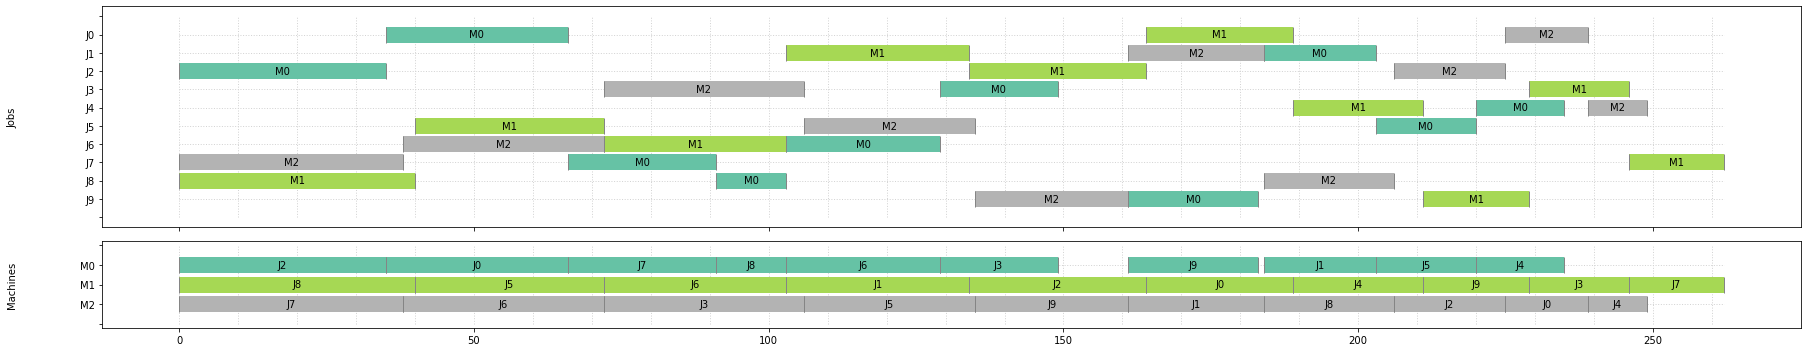

In [11]:
#-----------------------------------------------------------------------------
# Solve the model and display the result
#-----------------------------------------------------------------------------

# Display solution
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

if msol and visu.is_visu_enabled():
    visu.timeline("Solution for flow-shop ")
    visu.panel("Jobs")
    for i in range(nbrOfJobs):
        visu.sequence(name='J' + str(i),
                      intervals=[(msol.get_var_solution(job_operations_itv_vars[i][j]), j, 'M' + str(j)) for j in range(nbrOfMachines)])
    visu.panel("Machines")
    for j in range(nbrOfMachines):
        visu.sequence(name='M' + str(j),
                      intervals=[(msol.get_var_solution(job_operations_itv_vars[i][j]), j, 'J' + str(i)) for i in range(nbrOfJobs)])
    visu.show()